# Personal Information
Name: **Ana Negru**

StudentID: **12628859**

Email: [**ana.negru@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **22.03.2024**

# Data Context

This thesis project aims to explore and quantify social biases in LLMs fine-tuned for the task of question-answering. We use the following 3-step approach: examining bias in pre-training corpora, assessing
bias without fine-tuning, and evaluating bias post-fine-tuning using bias benchmarking methods from existing literature. The data that explored for this project thus consists of the Falcon LLM's pre-training corpus, RefinedWeb, and fine-tuning datasets SQuAD & NewsQA. For the purpose of this EDA, we'll be looking into the SQuAD question-answering dataset.

# Data Description

As RefinedWeb is almost 2TB in size, we do a preliminary analysis in this notebook streaming 1000 samples of the dataset below, which shows the top 20 occurring words in the samples, "one" being the highest occurring word with 1820 instances. 

Subsequently, bias is examined in the pre-training corpus by doing single word counts and co-occurrence word counts. 

For the single word counts we previously defined the following bias categories: jobs, pronouns, names, nationalities, religions and ethnicities and do word counts of all words within these categories. 

For co-occurrence categories we have the following: jobs & pronouns, jobs & names, jobs & nationalities, jobs & ethnicities, positive adjectives & nationalities, positive adjectives & ethnicities, positive adjectives & religions, negative adjectives & nationalities, negative adjectives & ethnicities, negative adjectives & religions.

We ran the counters on our corpus with 200 files from RefinedWeb and obtained preliminary results which are visualized below. We first show barcharts plotting the top 8 most occurring words from each bias category. For the co-occurrence charts we plot heatmaps depicting the positive adjective counts cooccurring with religion and ethnicity, as well as negative adjectives against ethnicity and religion. We also show co-occurrence count plots of jobs and pronouns, and jobs and ethnicities. 

When it comes to investigating the SQuAD dataset we looked into the distinct topic contexts that occur in the dataset.


github: https://github.com/ananegru/DS_Thesis/blob/master/EDA_Notebook.ipynb



In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import string
import re
import nltk
from datasets import load_dataset
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from ast import literal_eval

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
import gensim
from nltk.tokenize import RegexpTokenizer

In [45]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/ananegru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ananegru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [120]:
!jupyter nbconvert --to webpdf --allow-chromium-download EDA_Notebook.ipynb

[NbConvertApp] Converting notebook EDA_Notebook.ipynb to webpdf
[NbConvertApp] Writing 3082879 bytes to EDA_Notebook.pdf


# Pre-training Corpus Analysis

In [46]:
# Load the 'tiiuae/falcon-refinedweb' dataset in streaming mode, print out 1 row
dataset = load_dataset('tiiuae/falcon-refinedweb', 'en', split='train', streaming=True)

# retrieve 50 000 samples from refinedweb for inspection
samples = []
for i, sample in enumerate(dataset):
    samples.append(sample)
    if i == 49999:
        break

df = pd.DataFrame(samples)

In [47]:
# function to tokenize & clean the data for word counts

def clean_and_tokenize(sentence):
     #If the input is a list, join it into a single string
    if isinstance(sentence, list):
        sentence = ' '.join(sentence)

    sentence = re.sub(r'\-\-?', ' ', sentence)  
    sentence = re.sub('[^a-z A-Z]+', ' ', sentence) 
    sentence = sentence.lower()
    sentence = " ".join([word for word in sentence.split() if word not in stopwords.words('english')])

    tokens = word_tokenize(sentence)
    return [word for word in tokens]

df['content'] = df['content'].apply(clean_and_tokenize)

## Top Occurring Words in Sample From RefinedWeb Corpus

In [48]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['content'][i]
len(corpus)

mostCommon = Counter(corpus).most_common(20)
mostCommon

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 94821.72it/s]


[('one', 63001),
 ('like', 46061),
 ('time', 44233),
 ('new', 43333),
 ('would', 41991),
 ('also', 39252),
 ('get', 35323),
 ('people', 31893),
 ('first', 30192),
 ('said', 29020),
 ('may', 27874),
 ('make', 27274),
 ('us', 26419),
 ('well', 25929),
 ('year', 25698),
 ('good', 25632),
 ('see', 25447),
 ('two', 25239),
 ('know', 23643),
 ('love', 23419)]

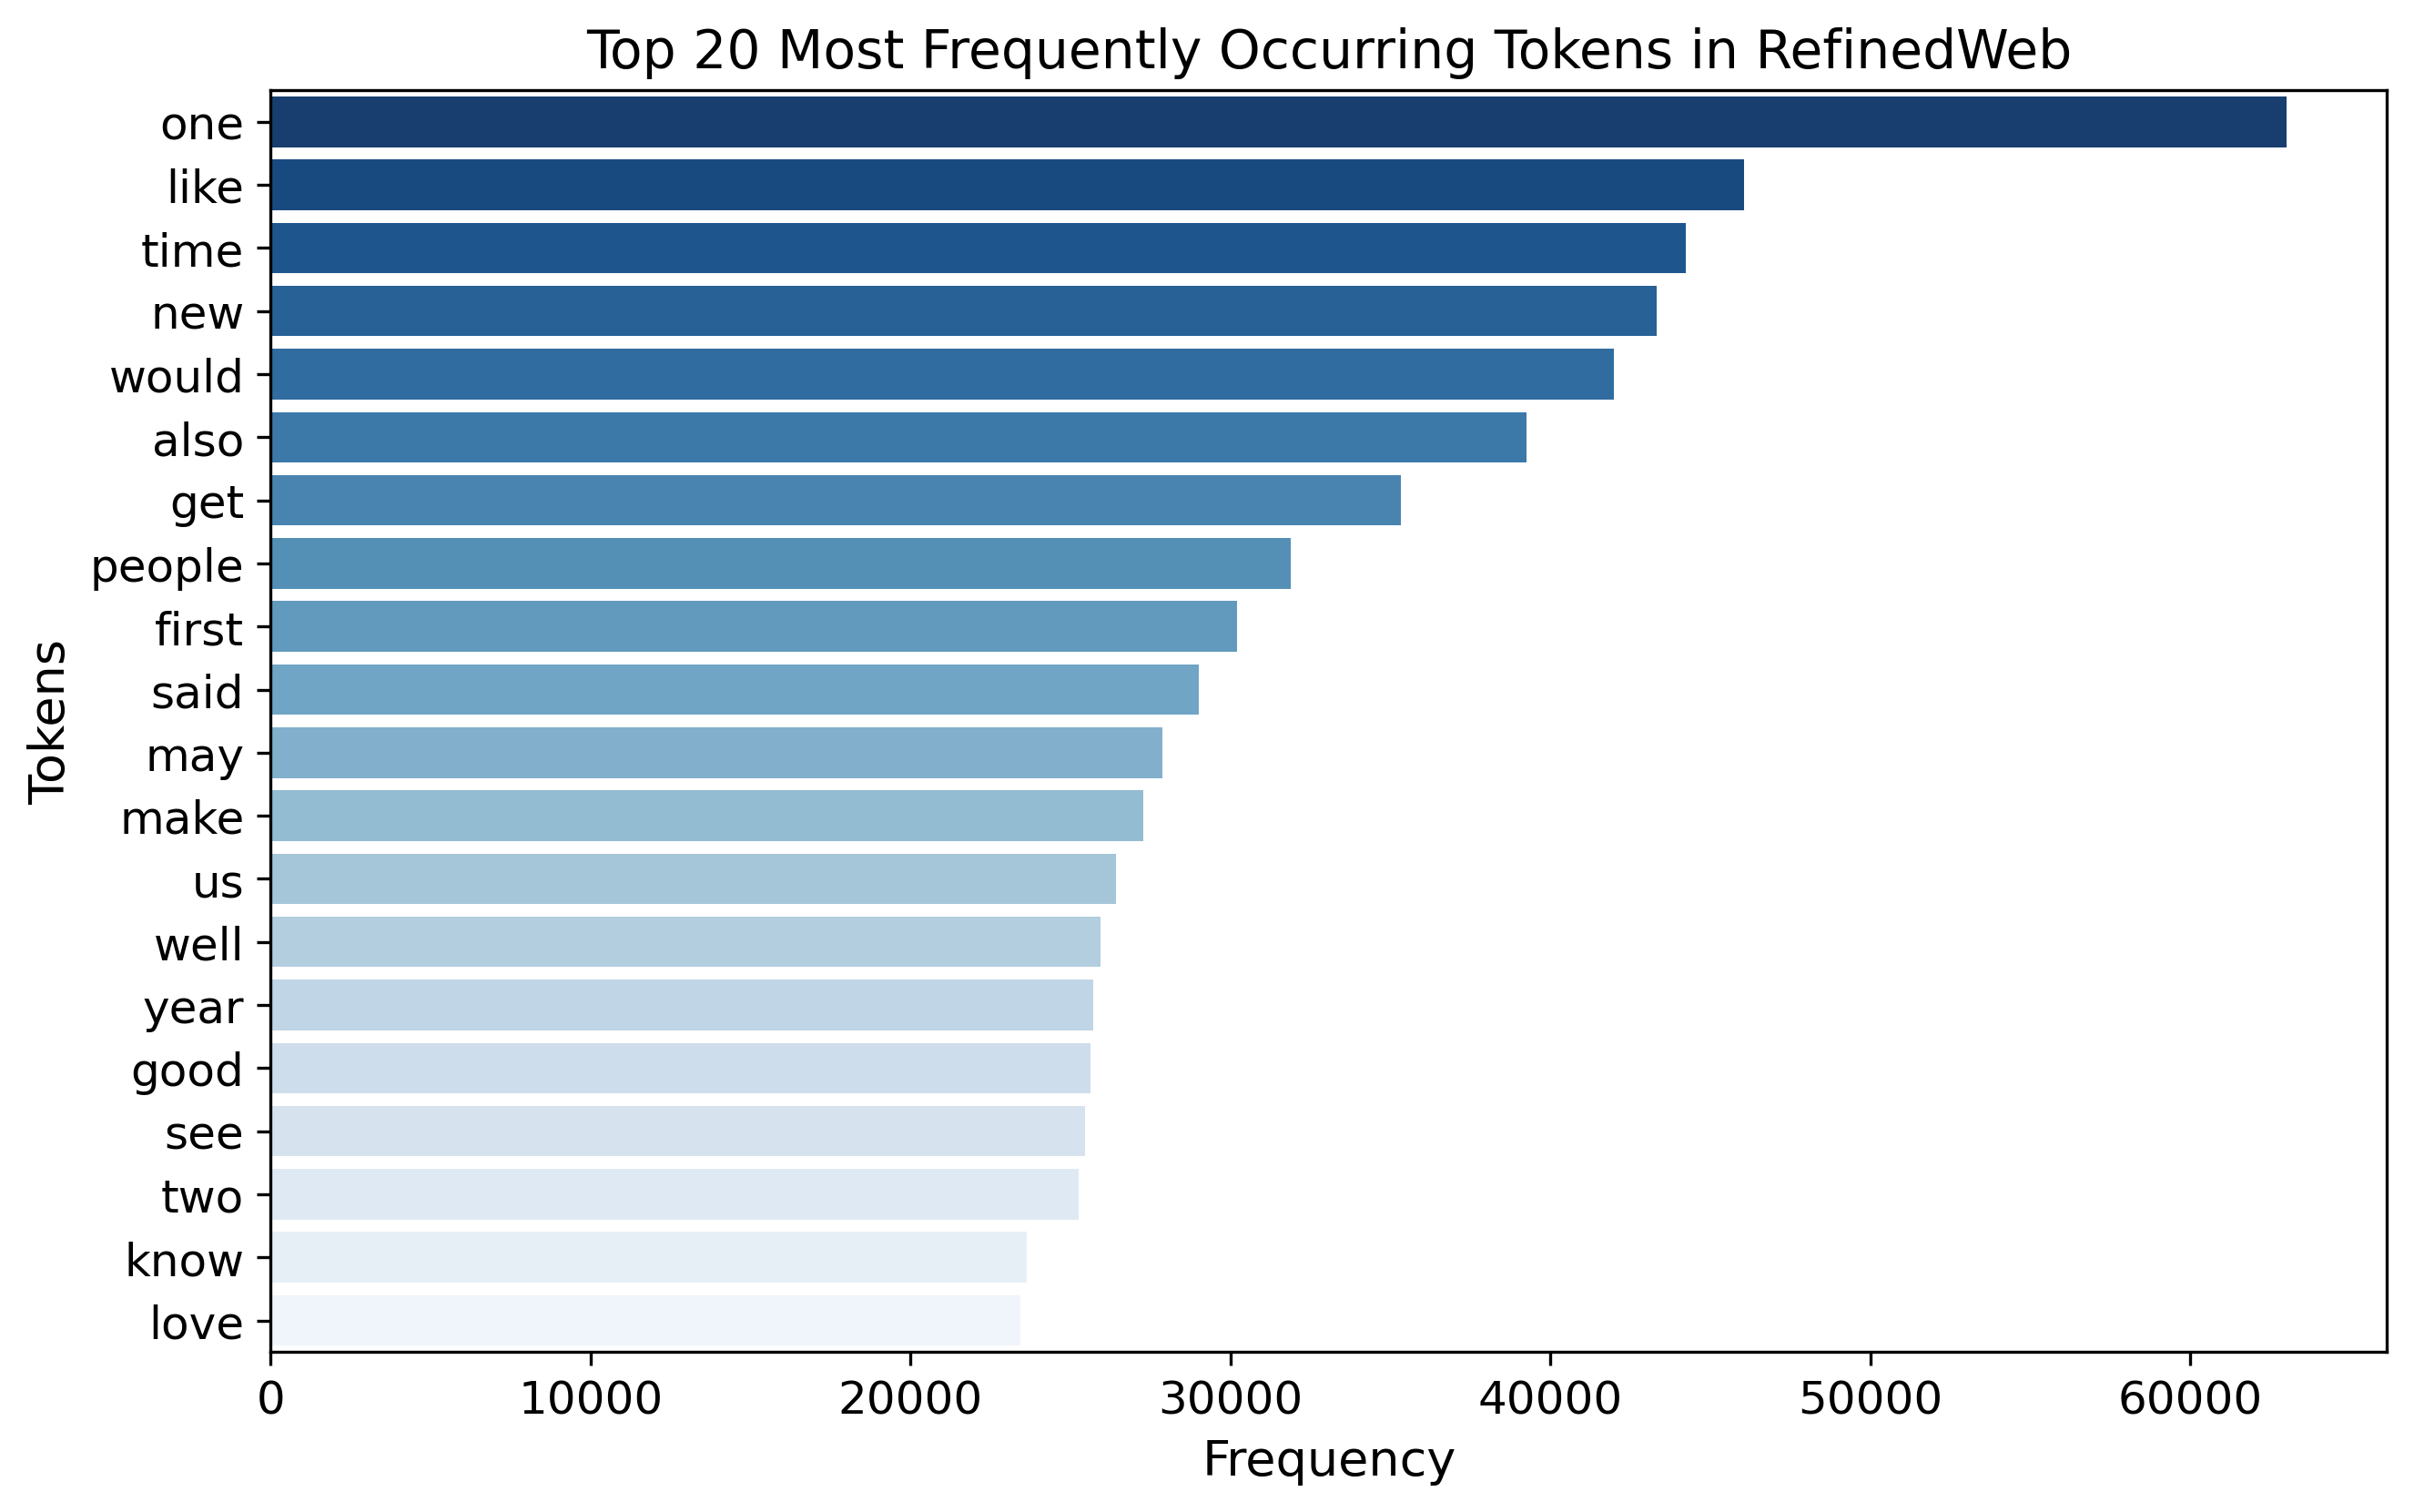

In [69]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)
    
# Generate the colors
colors = sns.color_palette("Blues", len(words))[::-1]  # Reverse the color palette

# Create the bar plot with the specified color scheme
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(x=freq, y=words, palette=colors)
plt.title('Top 20 Most Frequently Occurring Tokens in RefinedWeb', fontsize=14)
plt.xlabel('Frequency', fontsize=13)
plt.ylabel('Tokens', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Preliminary occurrence & co-occurrence results for a subset of files from the Pre-training corpus

In [59]:
directory = '/Users/ananegru/Documents/Thesis/Results'

single_counts = pd.DataFrame()
cooccurrence_counts = pd.DataFrame()

for filename in os.listdir(directory):
    if 'single_counts' in filename:
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        single_counts = pd.concat([single_counts, df], ignore_index=True)
        
for filename in os.listdir(directory):
    if 'cooccurrence_counts' in filename:
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        cooccurrence_counts = pd.concat([cooccurrence_counts, df], ignore_index=True)
    

In [60]:
# single word categories

single_jobs_df = single_counts.loc[single_counts['category'] == 'jobs']
single_pronouns_df = single_counts.loc[single_counts['category'] == 'pronouns']
single_names_df = single_counts.loc[single_counts['category'] == 'names']
single_religions_df = single_counts.loc[single_counts['category'] == 'religions']
single_nationalities_df = single_counts.loc[single_counts['category'] == 'nationalities']
single_ethnicities_df = single_counts.loc[single_counts['category'] == 'ethnicities']

In [61]:
# load co-occurrence categories

jobs_pronouns_cooccurrence = cooccurrence_counts.loc[cooccurrence_counts['category'] == 'jobs_pronouns']
jobs_names_cooccurrence = cooccurrence_counts.loc[cooccurrence_counts['category'] == 'jobs_names']
jobs_nationalities_cooccurrence = cooccurrence_counts.loc[cooccurrence_counts['category'] == 'jobs_nationalities']
jobs_ethnicities_cooccurrence = cooccurrence_counts.loc[cooccurrence_counts['category'] == 'jobs_ethnicities']

negative_nationalities_cooccurrence = cooccurrence_counts.loc[cooccurrence_counts['category'] == 'negative_nationalities']
negative_ethnicities_cooccurrence = cooccurrence_counts.loc[cooccurrence_counts['category'] == 'negative_ethnicities']
negative_religions_cooccurrence = cooccurrence_counts.loc[cooccurrence_counts['category'] == 'negative_religions']

positive_nationalities_cooccurrence = cooccurrence_counts.loc[cooccurrence_counts['category'] == 'positive_nationalities']
positive_ethnicities_cooccurrence = cooccurrence_counts.loc[cooccurrence_counts['category'] == 'positive_ethnicities']
positive_religions_cooccurrence = cooccurrence_counts.loc[cooccurrence_counts['category'] == 'positive_religions']

print(jobs_pronouns_cooccurrence)

             category                      pair  count
0       jobs_pronouns          ('judge', 'his')  23179
1       jobs_pronouns          ('chief', 'his')  19468
2       jobs_pronouns         ('lawyer', 'his')  20195
3       jobs_pronouns      ('executive', 'his')  11939
4       jobs_pronouns            ('CEO', 'his')   7536
...               ...                       ...    ...
651179  jobs_pronouns     ('developer', 'hers')      4
651180  jobs_pronouns       ('butcher', 'hers')      1
651181  jobs_pronouns     ('carpenter', 'hers')      1
651182  jobs_pronouns  ('carpenter', 'herself')      8
651183  jobs_pronouns       ('cashier', 'hers')      1

[12935 rows x 3 columns]


In [62]:
# sum single counts, order from descending

def summarize_and_sort_single(df):
    result = df.groupby('word', as_index=False)['count'].sum() # sum by word
    result_sorted = result.sort_values(by='count', ascending=False) # sort by largest value first
    return result_sorted


result_single_counts_jobs = summarize_and_sort_single(single_jobs_df)
result_single_counts_pronouns = summarize_and_sort_single(single_pronouns_df)
result_single_counts_names = summarize_and_sort_single(single_names_df)
result_single_counts_nationalities = summarize_and_sort_single(single_nationalities_df)
result_single_counts_religions = summarize_and_sort_single(single_religions_df)
result_single_counts_ethnicities = summarize_and_sort_single(single_ethnicities_df)


In [63]:
top_15_jobs = result_single_counts_jobs.head(15)
print(top_15_jobs)

         word   count
56      model  227320
38    general  217460
52    manager  101713
31     doctor   94919
32     driver   94814
23      coach   93456
80    teacher   90773
82     writer   76894
0         CEO   73441
36  executive   69818
20      chief   63514
47      judge   56043
25       cook   52500
33     editor   50656
49     lawyer   44938


In [64]:
top_10_jobs = result_single_counts_jobs.head(10)
print(top_15_jobs)

         word   count
56      model  227320
38    general  217460
52    manager  101713
31     doctor   94919
32     driver   94814
23      coach   93456
80    teacher   90773
82     writer   76894
0         CEO   73441
36  executive   69818
20      chief   63514
47      judge   56043
25       cook   52500
33     editor   50656
49     lawyer   44938


# Bar plots of the top 8 most often occurring word from the single words categories

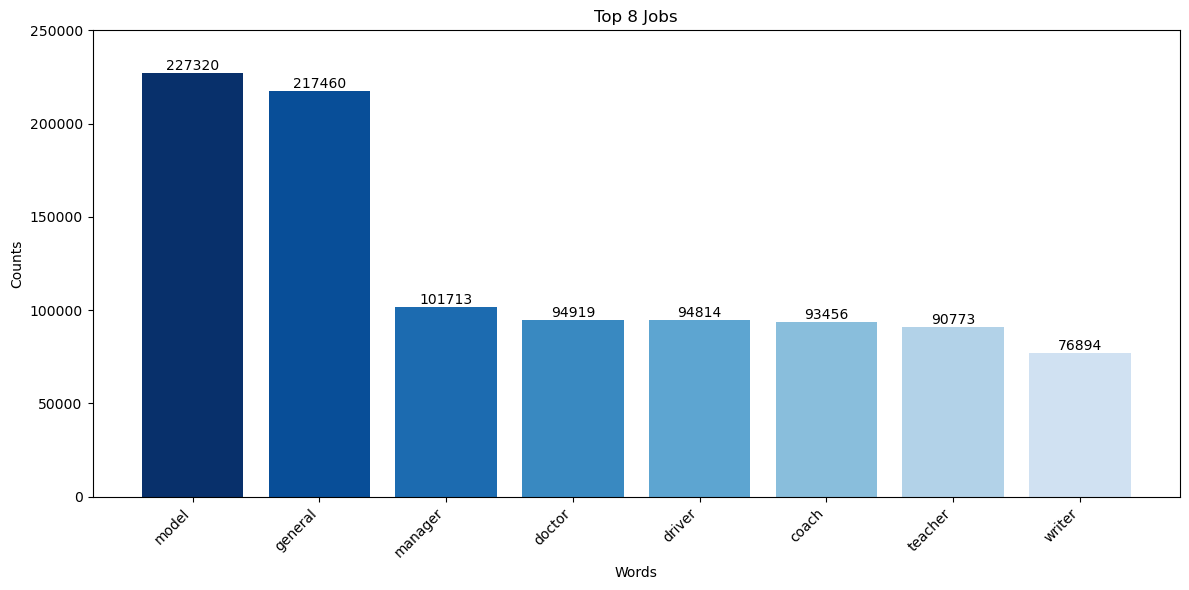

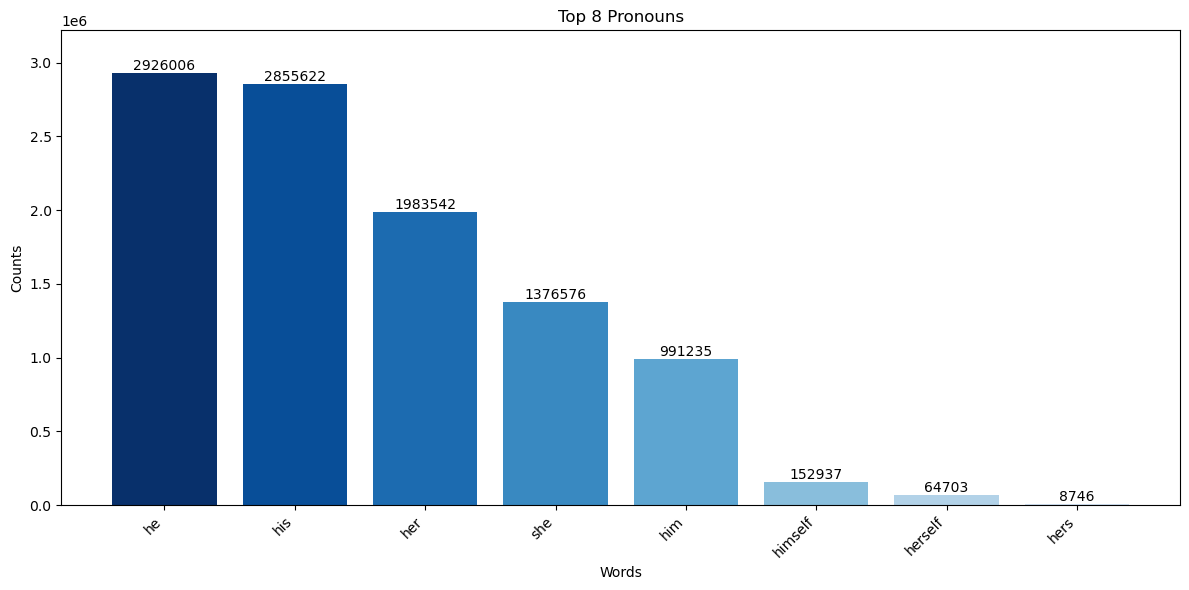

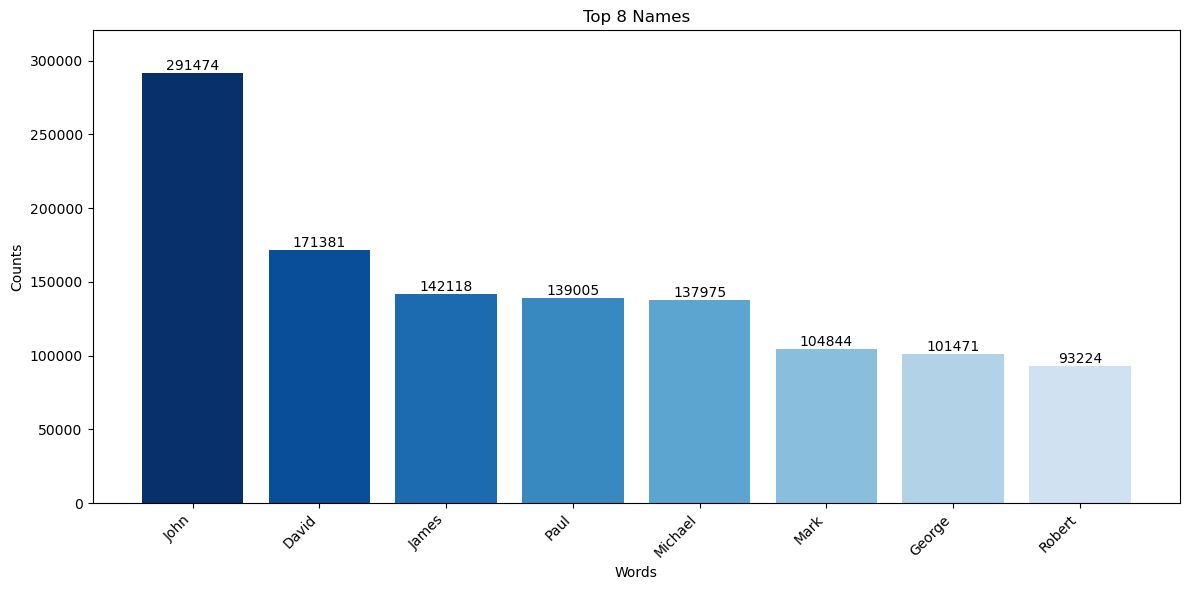

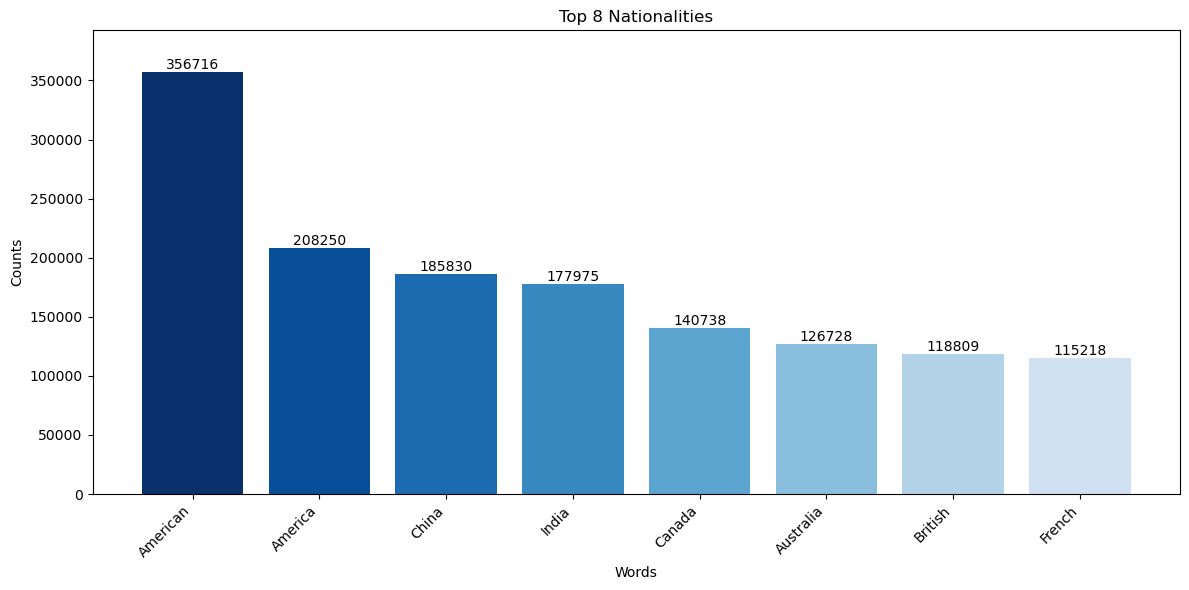

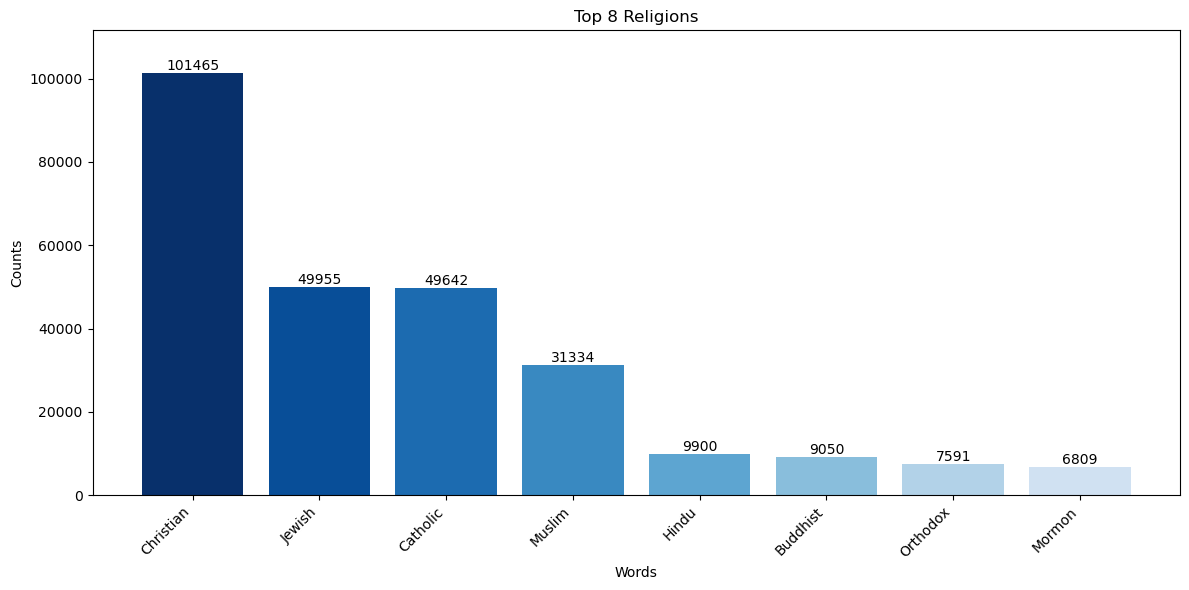

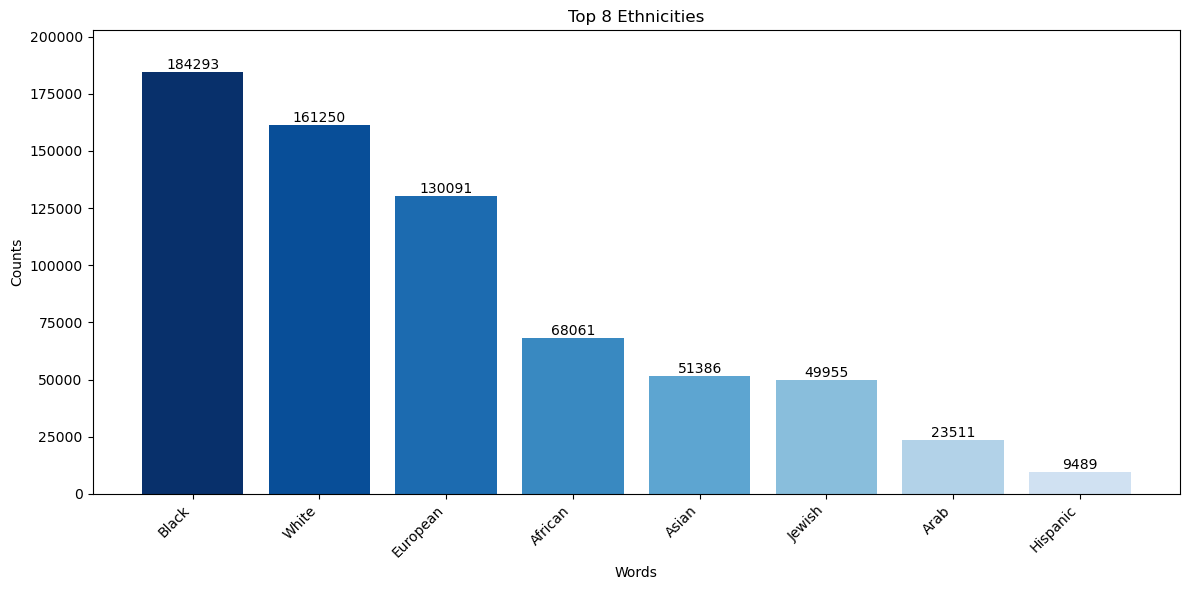

In [23]:
def plot_top8_barchart_with_reverse_gradient(df, title):
    top8_df = df.sort_values(by='count', ascending=False).head(8)
    
    cmap = plt.get_cmap('Blues_r')
    colors = cmap(np.linspace(0, 0.8, num=8))

    plt.figure(figsize=(12, 6))
    bars = plt.bar(top8_df['word'], top8_df['count'], color=colors)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Counts')

    plt.ylim(0, top8_df['count'].max() + (0.1 * top8_df['count'].max()))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.show()
    
plot_top8_barchart_with_reverse_gradient(result_single_counts_jobs, 'Top 8 Jobs')
plot_top8_barchart_with_reverse_gradient(result_single_counts_pronouns, 'Top 8 Pronouns')
plot_top8_barchart_with_reverse_gradient(result_single_counts_names, 'Top 8 Names')
plot_top8_barchart_with_reverse_gradient(result_single_counts_nationalities, 'Top 8 Nationalities')
plot_top8_barchart_with_reverse_gradient(result_single_counts_religions, 'Top 8 Religions')
plot_top8_barchart_with_reverse_gradient(result_single_counts_ethnicities, 'Top 8 Ethnicities')

# Heatmaps displaying the relationship between social bias categories and positive vs negative adjectives

In [11]:
# sum cooccurrence counts

def summarize_and_sort_cooccurrence(df):
    result = df.groupby('pair', as_index=False)['count'].sum() # sum by word
    result_sorted = result.sort_values(by='count', ascending=False) # sort by largest value first
    return result_sorted

result_cooccurrence_jobs_pronouns = summarize_and_sort_cooccurrence(jobs_pronouns_cooccurrence)
result_cooccurrence_jobs_names = summarize_and_sort_cooccurrence(jobs_names_cooccurrence)
result_cooccurrence_jobs_nationalities = summarize_and_sort_cooccurrence(jobs_nationalities_cooccurrence)
result_cooccurrence_jobs_ethnicities = summarize_and_sort_cooccurrence(jobs_ethnicities_cooccurrence)

result_cooccurrence_negative_nationalities = summarize_and_sort_cooccurrence(negative_nationalities_cooccurrence)
result_cooccurrence_negative_ethnicities = summarize_and_sort_cooccurrence(negative_ethnicities_cooccurrence)
result_cooccurrence_negative_religions = summarize_and_sort_cooccurrence(negative_religions_cooccurrence)

result_cooccurrence_positive_nationalities = summarize_and_sort_cooccurrence(positive_nationalities_cooccurrence)
result_cooccurrence_positive_ethnicities = summarize_and_sort_cooccurrence(positive_ethnicities_cooccurrence)
result_cooccurrence_positive_religions = summarize_and_sort_cooccurrence(positive_religions_cooccurrence)

In [12]:
top_15_jobs_cooccurrence = result_cooccurrence_jobs_pronouns.head(15)
print(top_15_jobs_cooccurrence)

                   pair    count
304   ('general', 'he')  1772105
310  ('general', 'his')  1701474
248    ('doctor', 'he')   900976
376     ('judge', 'he')   877493
160     ('chief', 'he')   800313
166    ('chief', 'his')   757828
184     ('coach', 'he')   733352
254   ('doctor', 'his')   712598
382    ('judge', 'his')   708450
661   ('writer', 'his')   680339
249   ('doctor', 'her')   677153
655    ('writer', 'he')   674659
305  ('general', 'her')   662248
447     ('model', 'he')   660202
416   ('manager', 'he')   653893


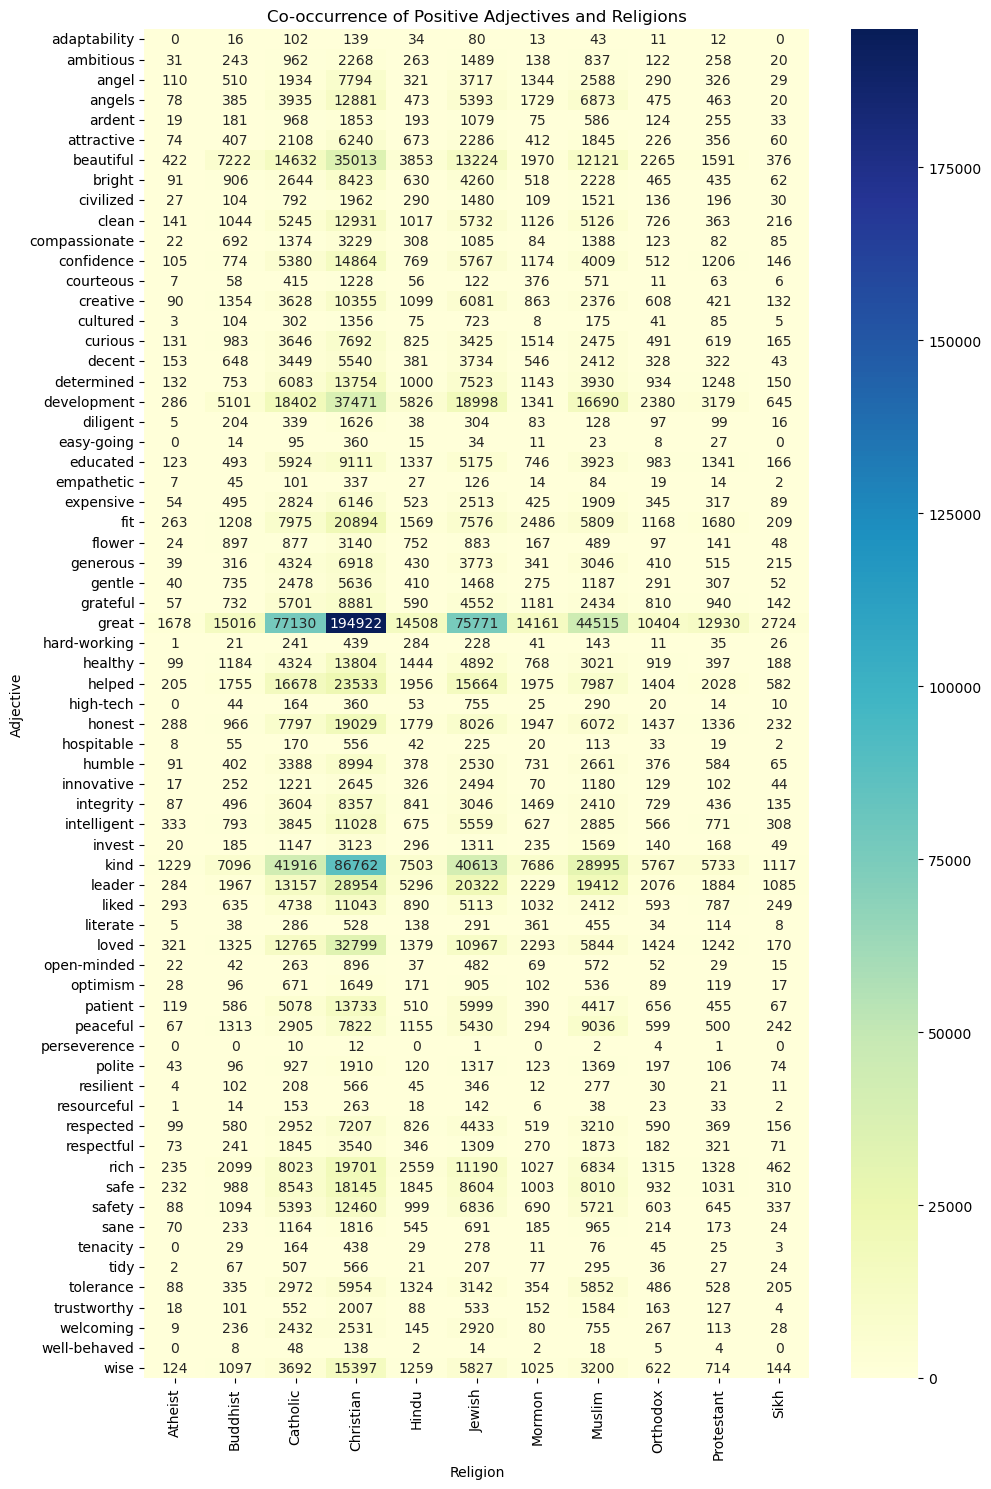

In [85]:
# positive adjectives & religions heatmap

# convert pair column from string to tuple
result_cooccurrence_positive_religions['pair'] = result_cooccurrence_positive_religions['pair'].apply(literal_eval)

# split pair column into 2 separate columns, to get adjective & religion
result_cooccurrence_positive_religions[['adjective', 'religion']] = pd.DataFrame(
    result_cooccurrence_positive_religions['pair'].tolist(), index=result_cooccurrence_positive_religions.index)

# drop original pair column
result_cooccurrence_positive_religions.drop('pair', axis=1, inplace=True)

# pivot df to create a matrix for heatmap
heatmap_data = result_cooccurrence_positive_religions.pivot_table(
    index='adjective', 
    columns='religion', 
    values='count', 
    fill_value=0)

plt.figure(figsize=(10, 15))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Co-occurrence of Positive Adjectives and Religions')
plt.xlabel('Religion')
plt.ylabel('Adjective')
plt.tight_layout()
plt.show()

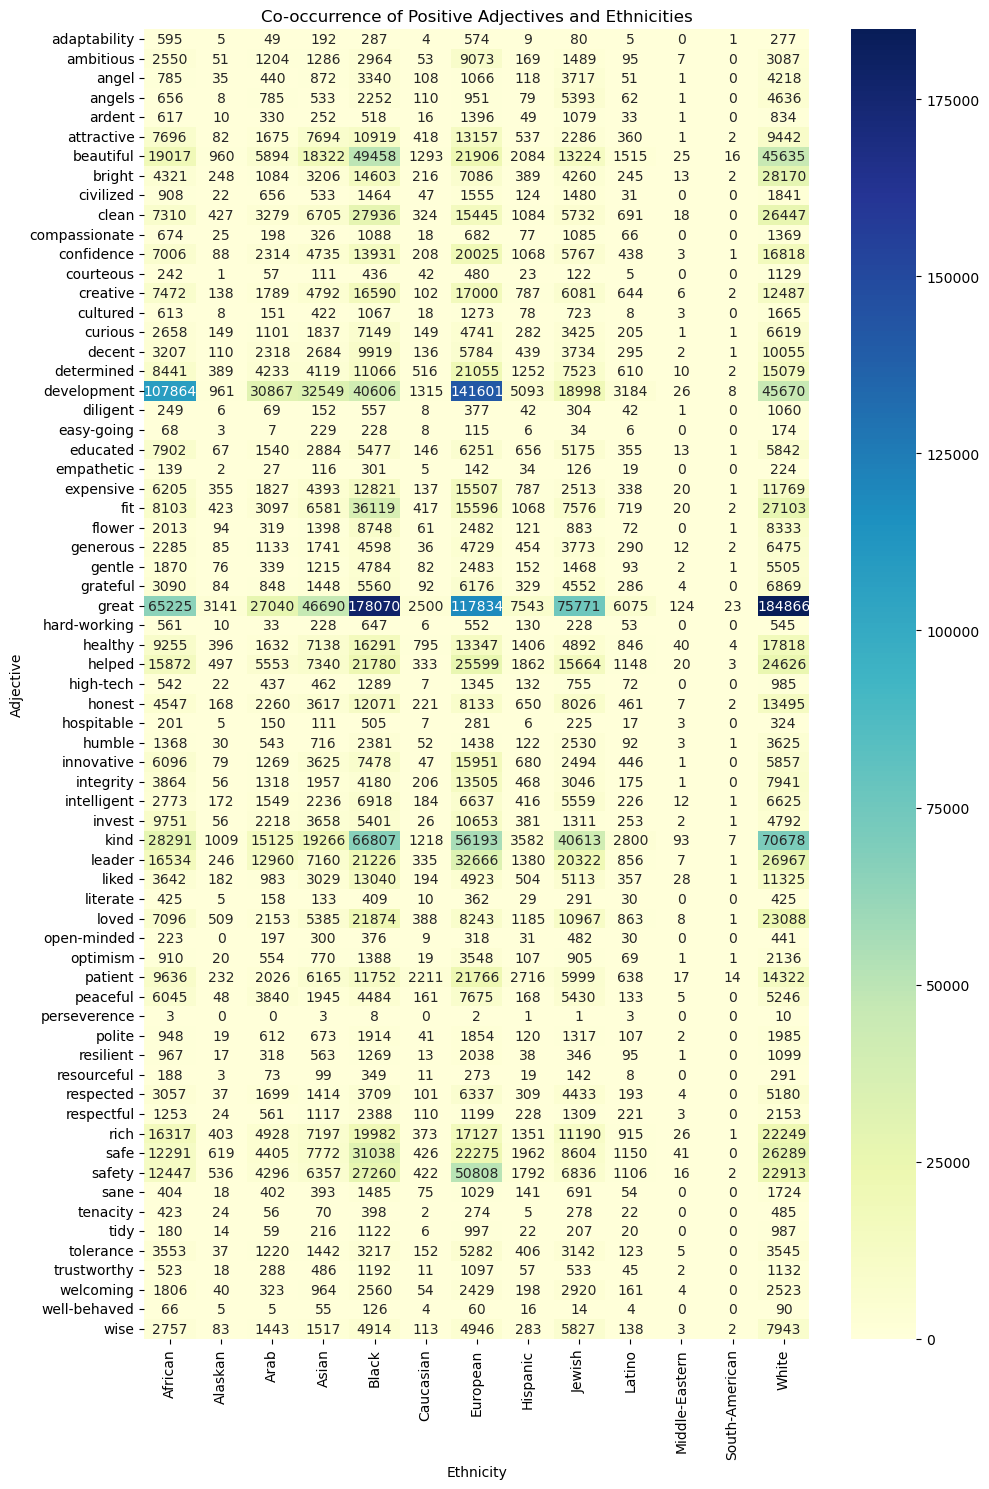

In [86]:
# positive adjectives & ethnicities

result_cooccurrence_positive_ethnicities['pair'] = result_cooccurrence_positive_ethnicities['pair'].apply(literal_eval)

result_cooccurrence_positive_ethnicities[['adjective', 'religion']] = pd.DataFrame(
    result_cooccurrence_positive_ethnicities['pair'].tolist(), index=result_cooccurrence_positive_ethnicities.index)

result_cooccurrence_positive_ethnicities.drop('pair', axis=1, inplace=True)

heatmap_data = result_cooccurrence_positive_ethnicities.pivot_table(
    index='adjective', 
    columns='religion', 
    values='count', 
    fill_value=0)

plt.figure(figsize=(10, 15))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Co-occurrence of Positive Adjectives and Ethnicities')
plt.xlabel('Ethnicity')
plt.ylabel('Adjective')
plt.tight_layout()
plt.show()


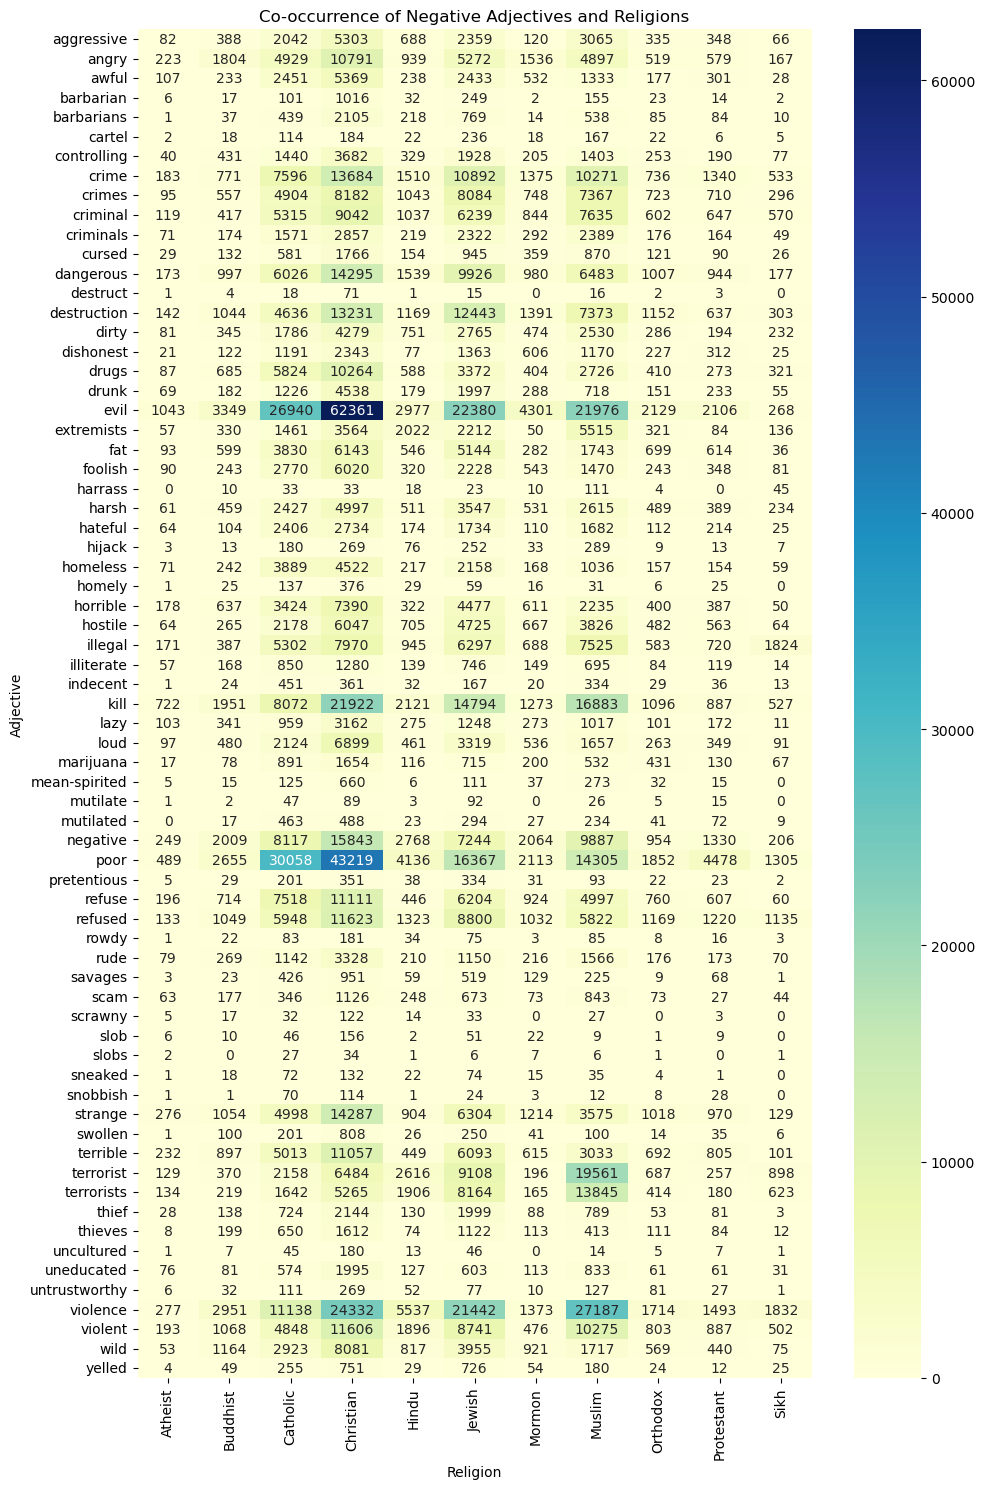

In [87]:
# negative adjectives & religions
result_cooccurrence_negative_religions['pair'] = result_cooccurrence_negative_religions['pair'].apply(literal_eval)

result_cooccurrence_negative_religions[['adjective', 'religion']] = pd.DataFrame(
    result_cooccurrence_negative_religions['pair'].tolist(), index=result_cooccurrence_negative_religions.index)

result_cooccurrence_negative_religions.drop('pair', axis=1, inplace=True)

heatmap_data = result_cooccurrence_negative_religions.pivot_table(
    index='adjective', 
    columns='religion', 
    values='count', 
    fill_value=0)

plt.figure(figsize=(10, 15))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Co-occurrence of Negative Adjectives and Religions')
plt.xlabel('Religion')
plt.ylabel('Adjective')
plt.tight_layout()
plt.show()


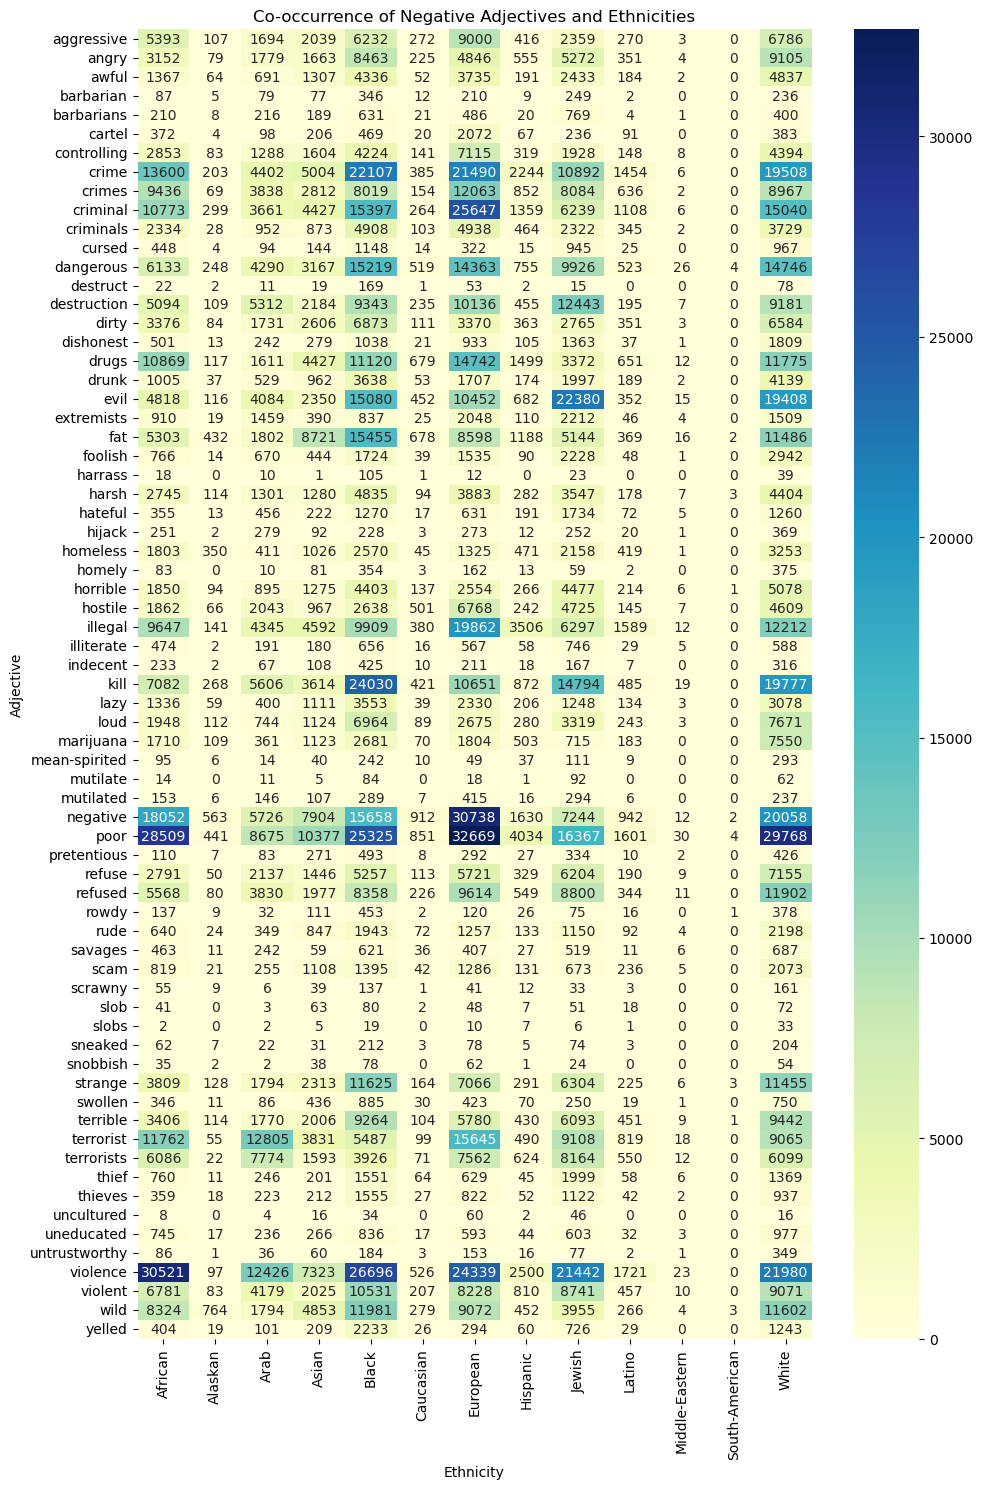

In [88]:
# negative adjectives & ethnicities
result_cooccurrence_negative_ethnicities['pair'] = result_cooccurrence_negative_ethnicities['pair'].apply(literal_eval)

result_cooccurrence_negative_ethnicities[['adjective', 'religion']] = pd.DataFrame(
    result_cooccurrence_negative_ethnicities['pair'].tolist(), index=result_cooccurrence_negative_ethnicities.index)

result_cooccurrence_negative_ethnicities.drop('pair', axis=1, inplace=True)

heatmap_data = result_cooccurrence_negative_ethnicities.pivot_table(
    index='adjective', 
    columns='religion', 
    values='count', 
    fill_value=0)

plt.figure(figsize=(10, 15))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Co-occurrence of Negative Adjectives and Ethnicities')
plt.xlabel('Ethnicity')
plt.ylabel('Adjective')
plt.tight_layout()
plt.show()

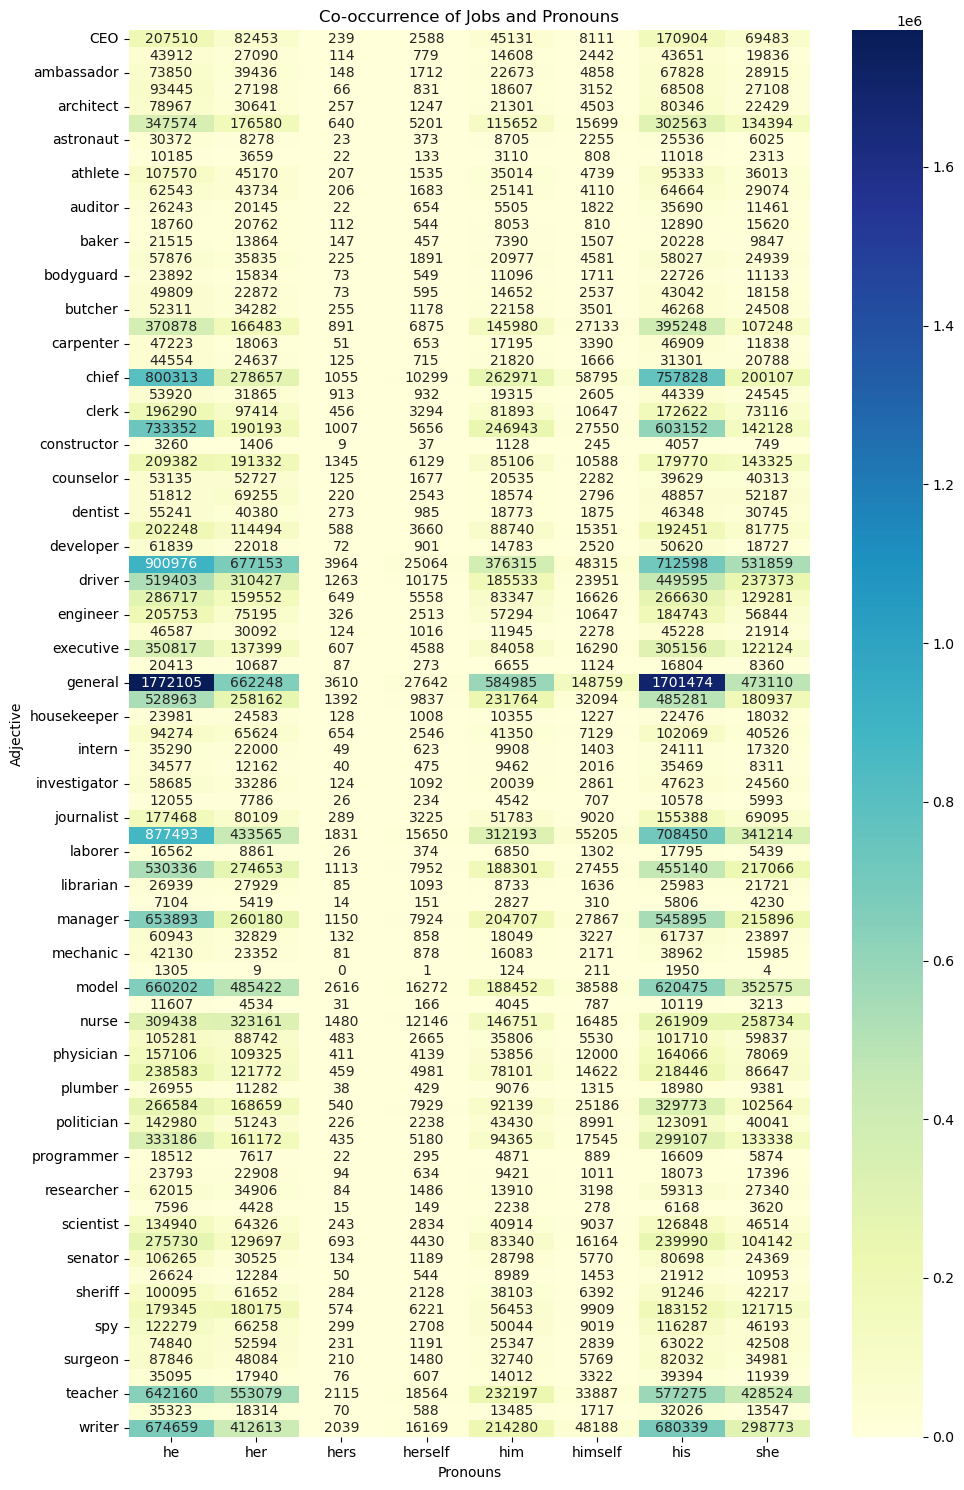

In [89]:
# jobs & pronouns
result_cooccurrence_jobs_pronouns['pair'] = result_cooccurrence_jobs_pronouns['pair'].apply(literal_eval)

result_cooccurrence_jobs_pronouns[['adjective', 'religion']] = pd.DataFrame(
    result_cooccurrence_jobs_pronouns['pair'].tolist(), index=result_cooccurrence_jobs_pronouns.index)

result_cooccurrence_jobs_pronouns.drop('pair', axis=1, inplace=True)

heatmap_data = result_cooccurrence_jobs_pronouns.pivot_table(
    index='adjective', 
    columns='religion', 
    values='count', 
    fill_value=0)

plt.figure(figsize=(10, 15))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Co-occurrence of Jobs and Pronouns')
plt.xlabel('Pronouns')
plt.ylabel('Adjective')
plt.tight_layout()
plt.show()

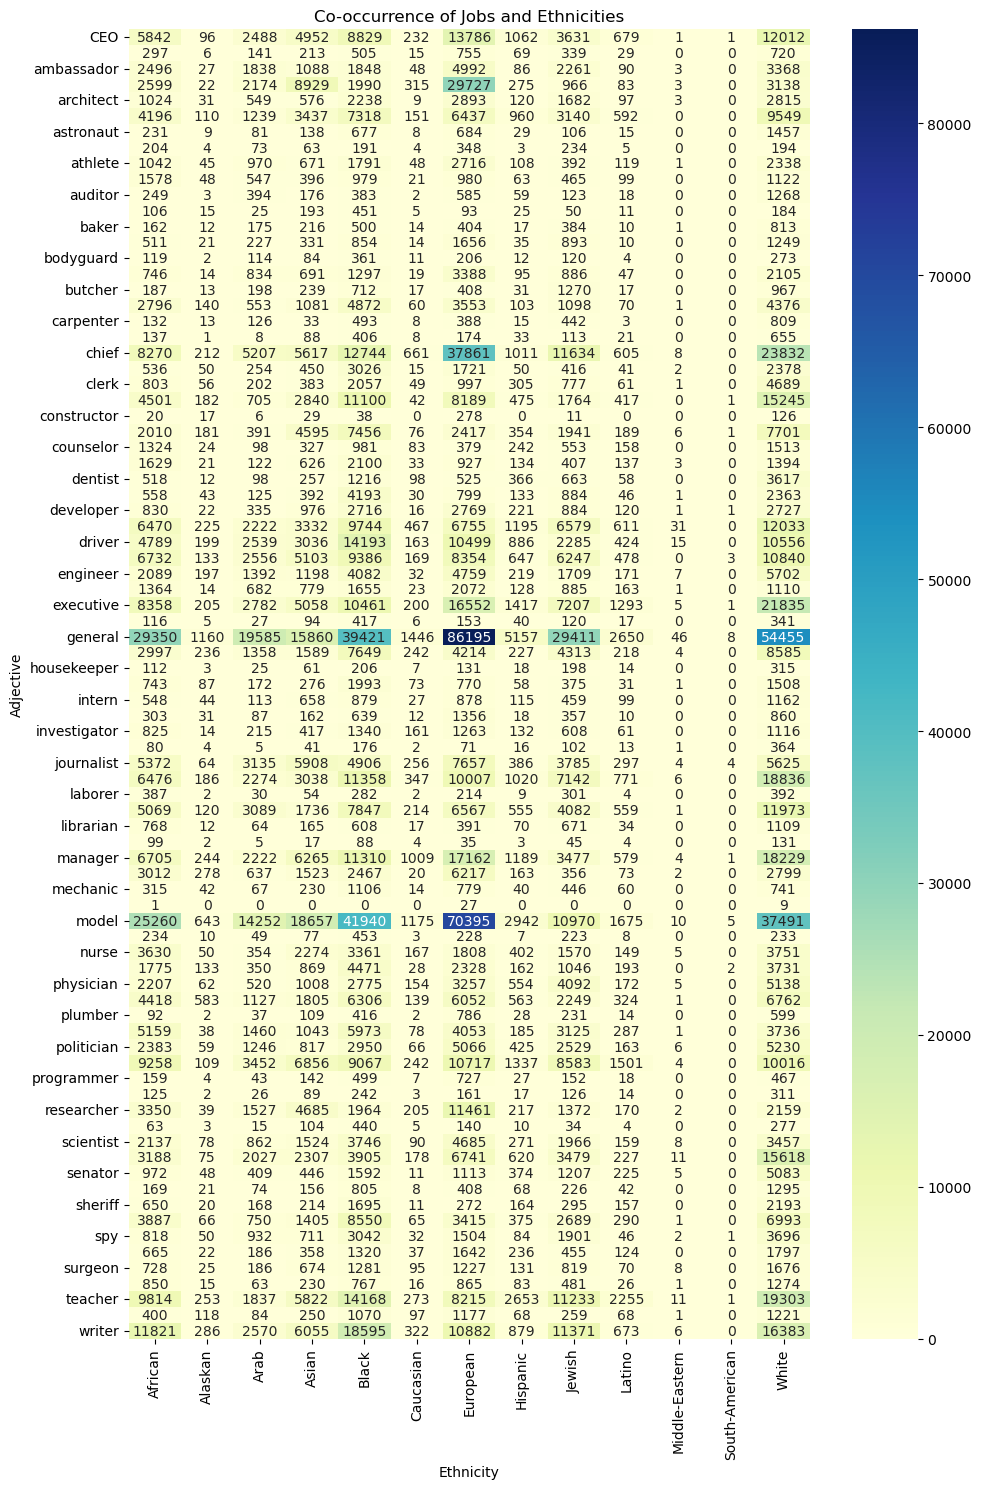

In [90]:
# jobs & ethnicities
result_cooccurrence_jobs_ethnicities['pair'] = result_cooccurrence_jobs_ethnicities['pair'].apply(literal_eval)

result_cooccurrence_jobs_ethnicities[['adjective', 'religion']] = pd.DataFrame(
    result_cooccurrence_jobs_ethnicities['pair'].tolist(), index=result_cooccurrence_jobs_ethnicities.index)

result_cooccurrence_jobs_ethnicities.drop('pair', axis=1, inplace=True)

heatmap_data = result_cooccurrence_jobs_ethnicities.pivot_table(
    index='adjective', 
    columns='religion', 
    values='count', 
    fill_value=0)

plt.figure(figsize=(10, 15))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Co-occurrence of Jobs and Ethnicities')
plt.xlabel('Ethnicity')
plt.ylabel('Adjective')
plt.tight_layout()
plt.show()

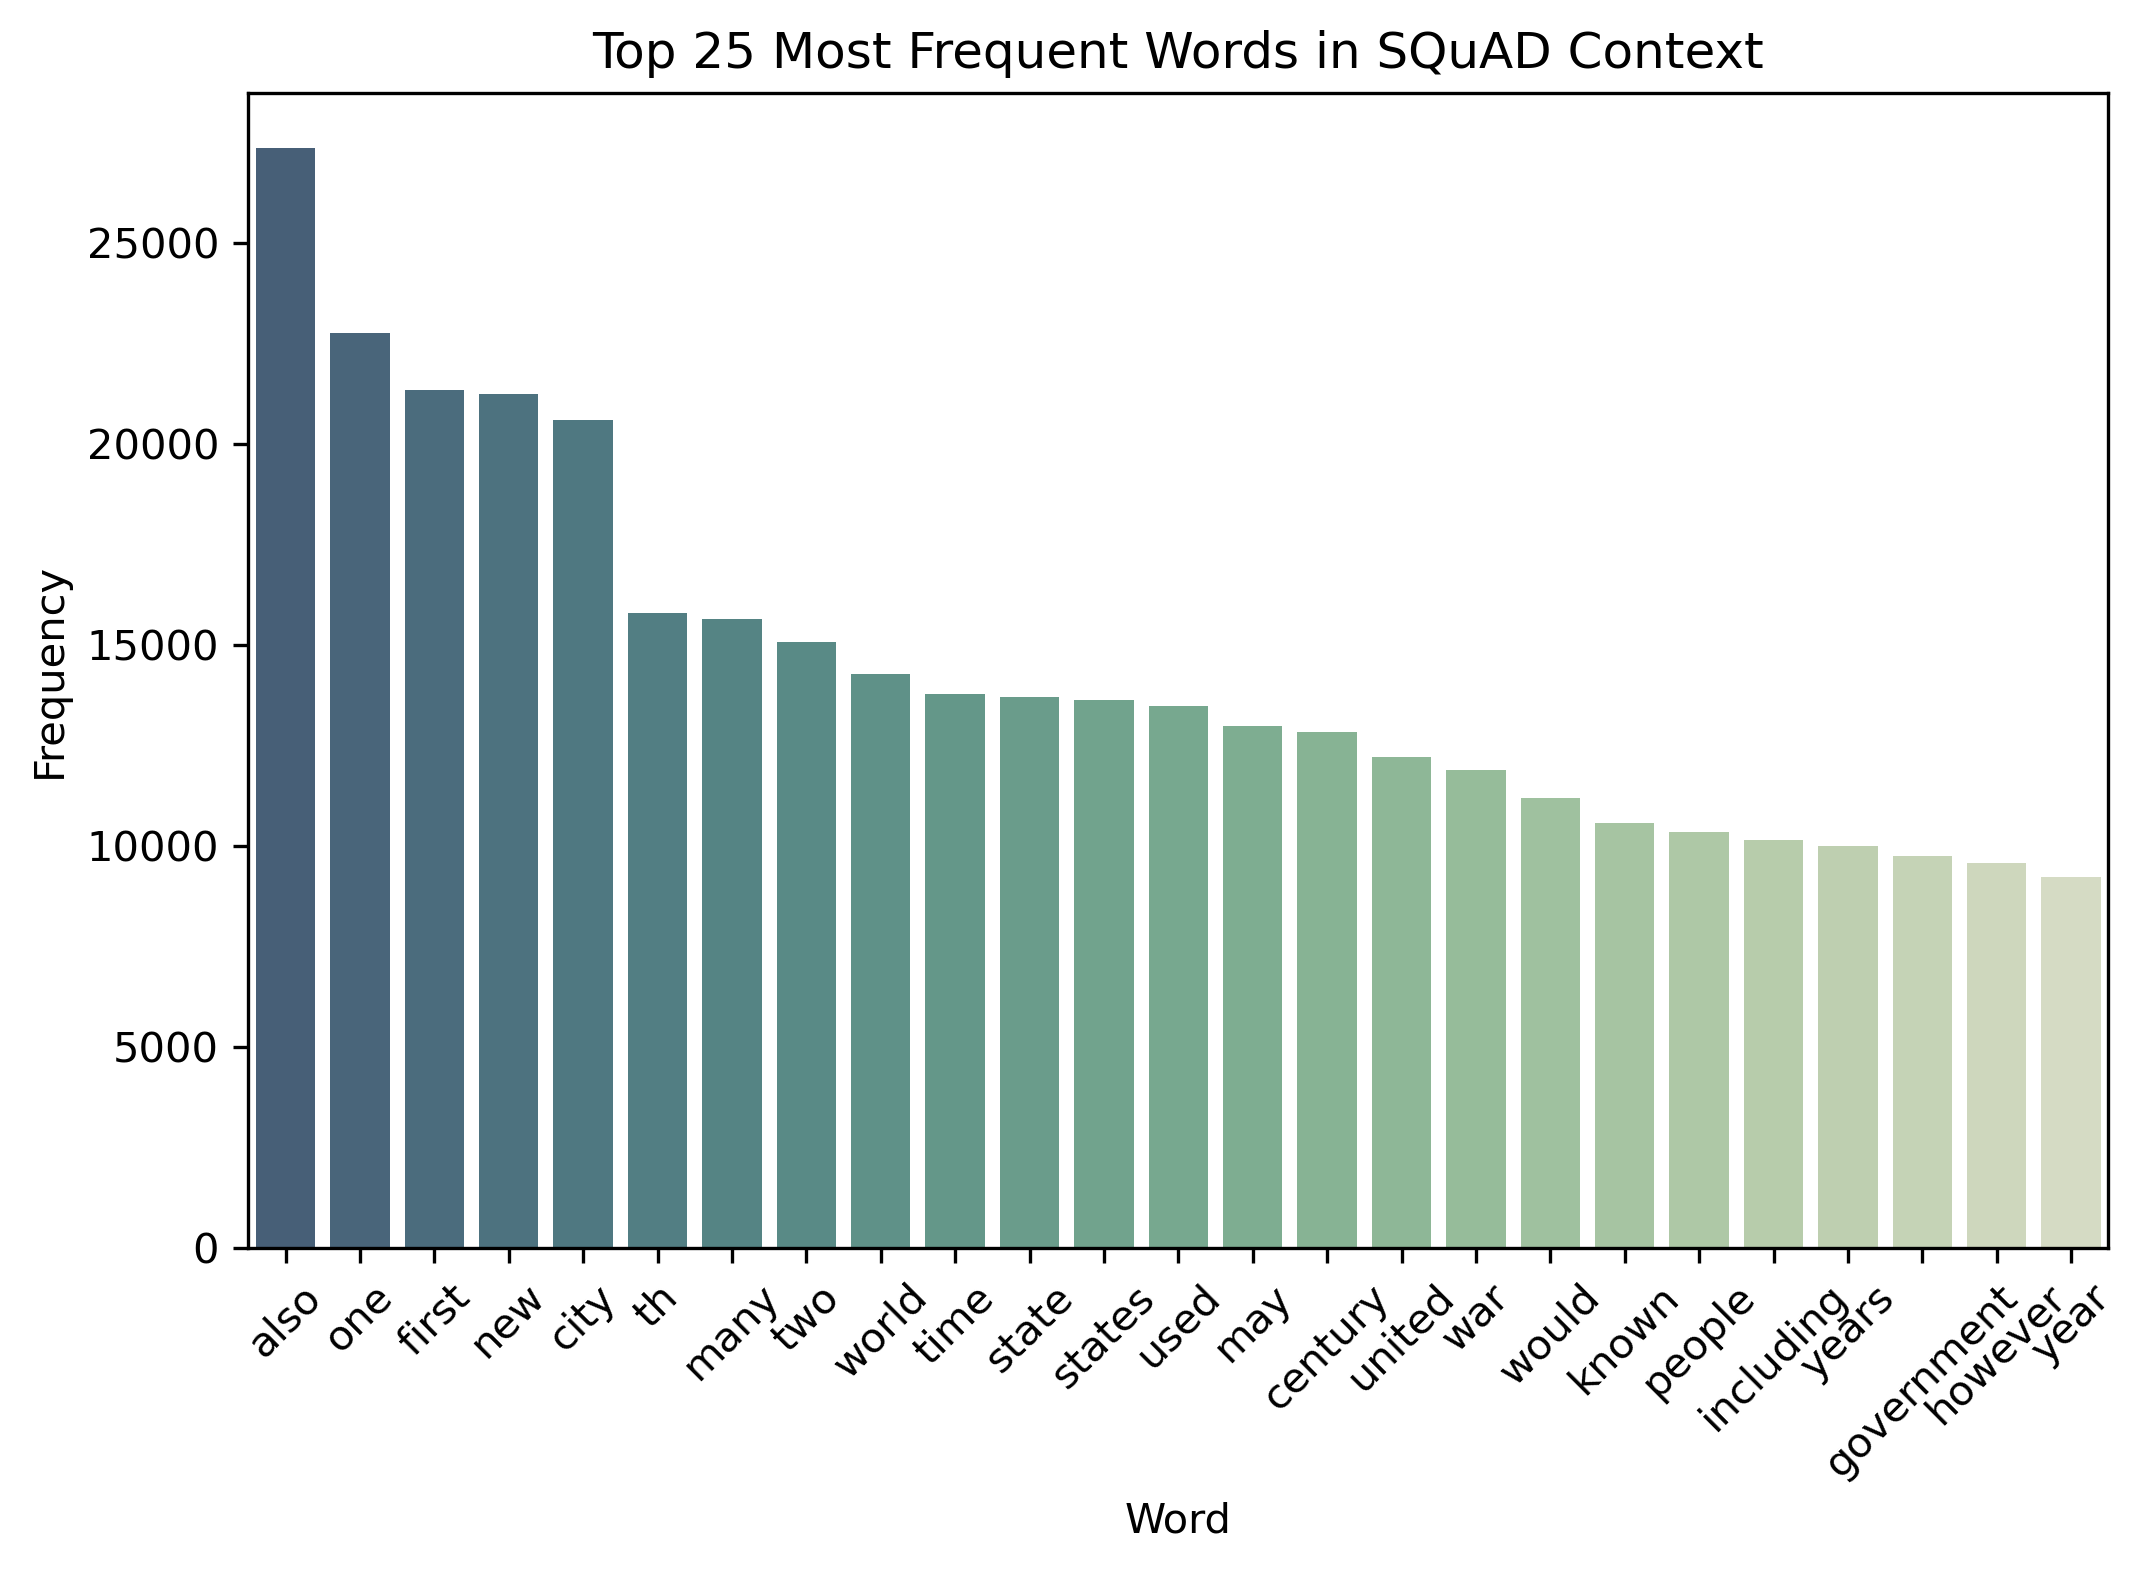

In [21]:
def clean_and_tokenize(sentence):
    if isinstance(sentence, list):
        sentence = ' '.join(sentence)

    # Replace double dashes with a single space, and remove non-alphabet characters
    sentence = re.sub(r'\-\-?', ' ', sentence)
    sentence = re.sub('[^a-z A-Z]+', ' ', sentence)
    sentence = sentence.lower()
    sentence = " ".join([word for word in sentence.split() if word not in stop_words])

    # Tokenize the cleaned sentence
    tokens = word_tokenize(sentence)
    return tokens

# Count the frequency of words in the 'context' column
word_counts = Counter()
train_squad['context'].apply(lambda x: word_counts.update(clean_and_tokenize(x)))

# Get the most common 25 words
most_common_words = word_counts.most_common(25)

# Create a DataFrame from the most common words for visualization
words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Create a blue cubehelix palette
palette = sns.cubehelix_palette(25, start=.5, rot=-.75, light=0.85, dark=0.35, reverse=True)

# Plotting with words on the x-axis and frequency on the y-axis
plt.figure(figsize=(8, 5), dpi=300)
sns.barplot(x='Word', y='Frequency', data=words_df, palette=palette)
plt.title('Top 25 Most Frequent Words in SQuAD Context')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the words on x-axis for better visibility
plt.show()

In [26]:
def tokenize_only(sentence):
    # If the input is a list, join it into a single string
    if isinstance(sentence, list):
        sentence = ' '.join(sentence)

    # Preprocessing the sentence
    sentence = re.sub(r'\-\-?', ' ', sentence)
    sentence = re.sub('[^a-z A-Z]+', ' ', sentence)
    sentence = sentence.lower()
    tokens = word_tokenize(sentence)
    return [word for word in tokens if word not in stop_words]

# Tokenize and count words in the 'context' column
train_squad['word_count'] = train_squad['context'].apply(lambda x: len(tokenize_only(x)))

# Calculate statistics
mean_word_count = train_squad['word_count'].mean()
std_dev_word_count = train_squad['word_count'].std()
max_word_count = train_squad['word_count'].max()
median_word_count = train_squad['word_count'].median()
min_word_count = train_squad['word_count'].min()

# Display the statistics
print("Mean word count:", mean_word_count)
print("Standard deviation of word count:", std_dev_word_count)
print("Maximum word count:", max_word_count)
print("Minimum word count:", min_word_count)
print("Median word count:", median_word_count)

Mean word count: 70.11922510530943
Standard deviation of word count: 28.963154151782444
Maximum word count: 359
Minimum word count: 8
Median word count: 65.0


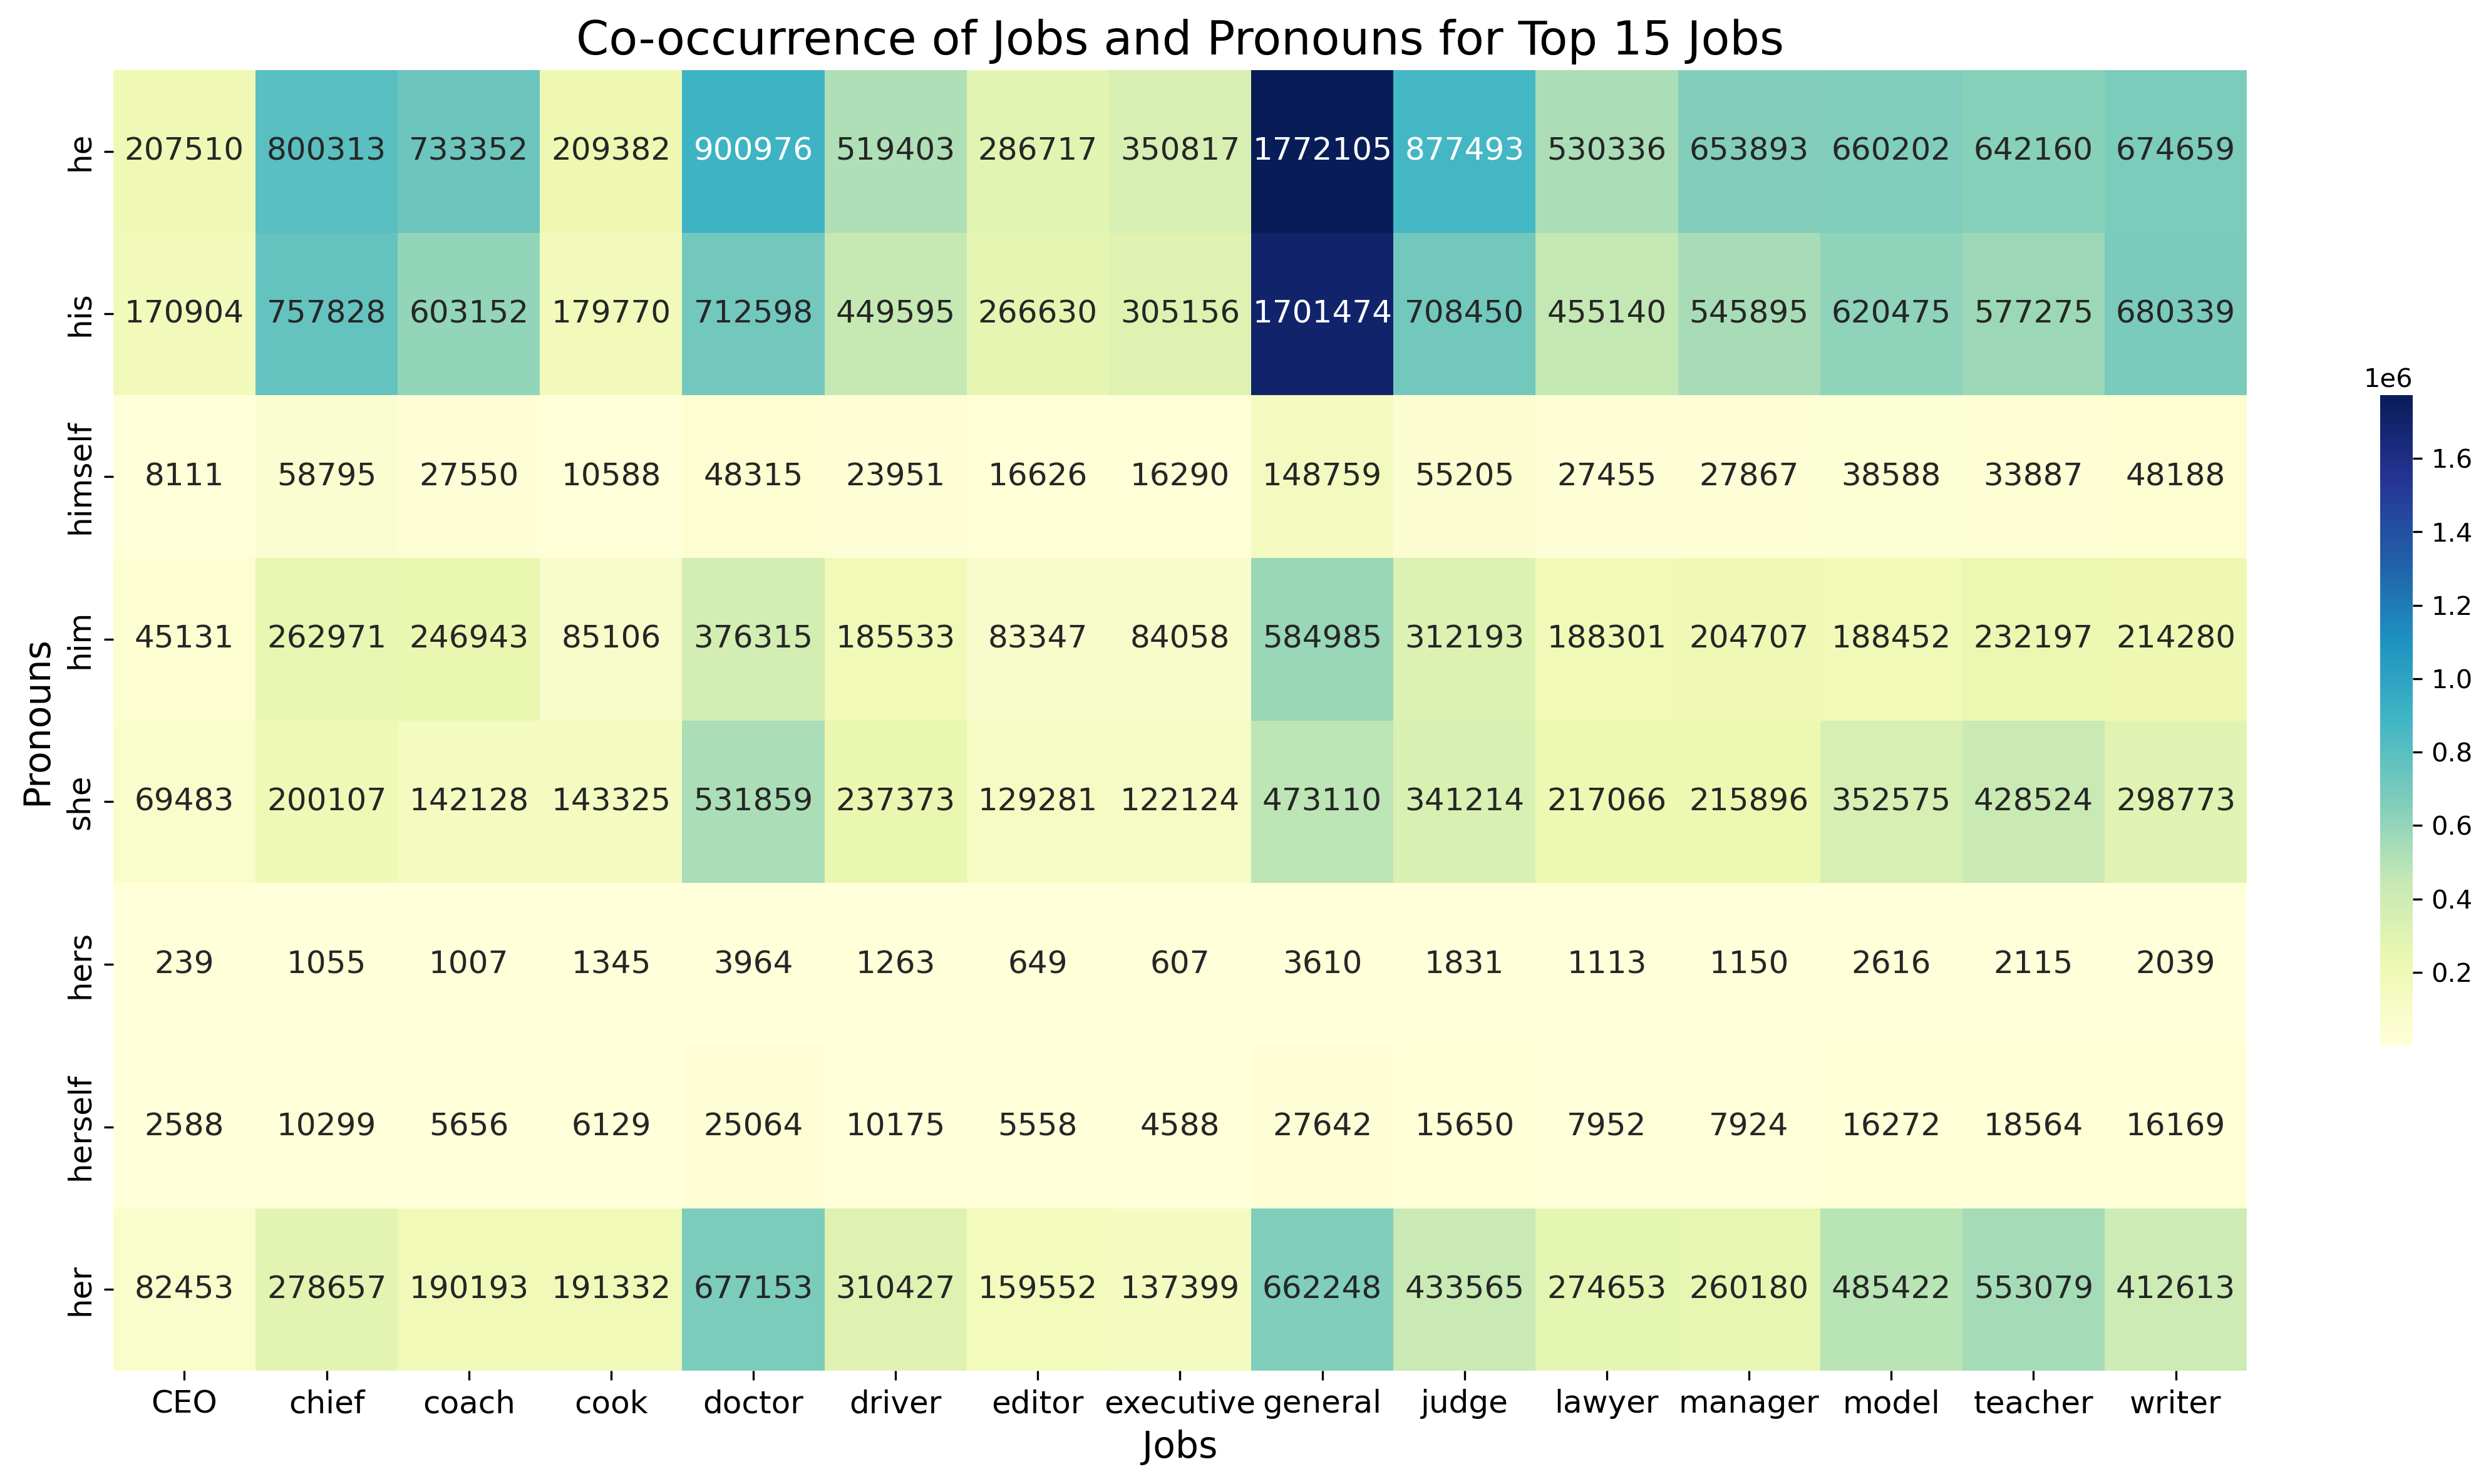

In [72]:
jobs_to_include = [
    'model', 'general', 'manager', 'doctor', 'driver', 'coach', 
    'teacher', 'writer', 'CEO', 'executive', 'chief', 'judge', 
    'cook', 'editor', 'lawyer'
]

pronoun_order = ['he', 'his', 'himself', 'him', 'she', 'hers', 'herself', 'her']

filtered_data = result_cooccurrence_jobs_pronouns[result_cooccurrence_jobs_pronouns['adjective'].isin(jobs_to_include)]

heatmap_data = filtered_data.pivot_table(
    index='pronoun', 
    columns='adjective', 
    values='count', 
    fill_value=0
)

heatmap_data = heatmap_data.reindex(pronoun_order)

plt.figure(figsize=(15, 8), dpi=300)
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'shrink': 0.5}, annot_kws={"size": 12})
plt.title('Co-occurrence of Jobs and Pronouns for Top 15 Jobs', fontsize=18)
plt.xlabel('Jobs', fontsize=14)
plt.ylabel('Pronouns', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
